In [1]:
import random
import numpy as np
import pandas as pd
from itertools import chain, combinations

import dask
from dask.distributed import Client, progress

/home/curtis/miniconda3/envs/powerset-dev/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/curtis/miniconda3/envs/powerset-dev/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:35301 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 25.31 GB


In [3]:
# initial parameters
random.seed(1234)
num_ids = 10000
num_vars = 15

# create repeating IDs
ids = sorted(list(range(0, num_ids)) * num_vars)

# create repeating variables
variables = list(range(0, num_vars)) * num_ids

# create random integers
values = np.random.randint(1, 5, size = num_ids * num_vars)

In [4]:
# create a dataframe with these values
df = pd.DataFrame({"id": ids, "variable": variables, "values": values})

# sort the dataframe
df.sort_values(['id', 'variable'], inplace=True)

In [5]:
def powerset(iterable):
    """
    Thanks to https://stackoverflow.com/questions/1482308
    """
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [6]:
# create every subset of variables
subsets = list(powerset(set(variables)))

# how many items?
len(subsets)

32768

In [7]:
def calculate(df, variables):
    
    """
    Subset the dataframe to only include specified variables
    and calculate the average scores per ID
    """
    
    # filter the dataframe to only the variables in the subset
    sub = df[df['variable'].isin(variables)]

    # group by ID and calculate average value
    scores = sub.groupby('id')['values'].mean()
    
    return scores

In [8]:
def correlalate(actual, subset):
    
    """
    Calculate the correlation between the actual and subset
    """
    
    return actual.corr(subset)

In [9]:
# make the functions lazy
calculate = dask.delayed(calculate)
correlalate = dask.delayed(correlalate)

In [10]:
# call the dask functions
actual = calculate(df, set(variables))
subset = calculate(df, list(set(variables))[:5])
cor = correlalate(actual, subset)

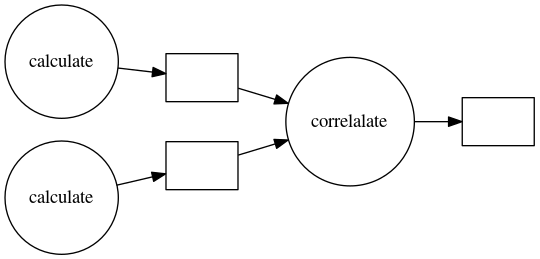

In [11]:
# visualize computation
cor.visualize(rankdir="LR")

In [12]:
%%time

# run computation
cor.compute()

CPU times: user 53.6 ms, sys: 21.6 ms, total: 75.3 ms
Wall time: 150 ms


/home/curtis/miniconda3/envs/powerset-dev/lib/python3.7/site-packages/distributed/worker.py:2791: UserWarning: Large object of size 4.80 MB detected in task graph: 
  (          id  variable  values
0          0       ... 0, 1, 2, 3, 4])
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


0.5666892128285912

In [13]:
%%time

# create a dictionary to hold the results
results = []

# iterate over each subset
for s in subsets:

    # make sure there is at least 1 variable...
    if len(s) > 0:
        
        # calculate the values on the filtered dataframe
        sub = calculate(df, s)
        
        # calculate the correlation
        corr = correlalate(actual, sub)

        # add results to dictionary
        results.append((s, corr))
        
results = dask.persist(*results)
total = dask.delayed(results)

CPU times: user 21.5 s, sys: 3.65 s, total: 25.2 s
Wall time: 24.5 s


In [14]:
%%time

# start computation
data = total.compute()

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.batched - ERROR - Error in batched write
Traceback (most recent call last):
  File "/home/curtis/miniconda3/envs/powerset-dev/lib/python3.7/site-packages/distributed/batched.py", line 94, in _background_send
    on_error='raise')
  File "/home/curtis/miniconda3/envs/powerset-dev/lib/python3.7/site-packages/tornado/gen.py", line 729, in run
    value = future.result()
  File "/home/curtis/miniconda3/envs/powerset-dev/lib/python3.7/site-packages/tornado/gen.py", line 736, in run
    yielded = self.gen.throw(*exc_info)  # type: ignore
  File "/home/curtis/miniconda3/envs/powerset-dev/lib/python3.7/site-packages/distributed/comm/tcp.py", line 224, in write
    'recipient': self._peer_addr})
  File "/home/curtis/miniconda3/envs/powerset-dev/lib/python3.7/site-packages/tornado/gen.py", line 729, in run
    value = future.result()
  File "/home/curtis/miniconda3/envs/powerset-dev/lib/python3.7/site-packages/tornado/gen.py", line 736, in run
    yielded = self.gen.throw(*exc_info) 

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

KeyboardInterrupt: 